In [23]:
from models_dif import TMC,SoftmaxWeight,LocationScaleFlow
from targets.variational_inference_target import *
import torch
import matplotlib.pyplot as plt

In [24]:
from matplotlib.colors import ListedColormap
import numpy as np
N = 256
orange = np.ones((N, 4))
orange[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
orange[:, 1] = np.geomspace(165 / 256, 1, N)  # G = 165
orange[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
orange_cmap = ListedColormap(orange[::-1])

orange_color = "#FFA500"

red = np.ones((N, 4))
red[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
red[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
red[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
red_cmap = ListedColormap(red[::-1])

red_color = "#FF0000"

blue = np.ones((N, 4))
blue[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
blue[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
blue[:, 2] = np.geomspace(255 / 256, 1, N)  # B = 255
blue_cmap = ListedColormap(blue[::-1])

blue_color = "#0000FF"

green = np.ones((N, 4))
green[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
green[:, 1] = np.geomspace(128 / 256, 1, N)  # G = 128
green[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 128
green_cmap = ListedColormap(green[::-1])

green_color = "#008000"

pink = np.ones((N, 4))
pink[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
pink[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
pink[:, 2] = np.geomspace(211 / 256, 1, N)  # B = 211
pink_cmap = ListedColormap(pink[::-1])

pink_color = "#FF00D3"

purple = np.ones((N, 4))
purple[:, 0] = np.geomspace(51 / 256, 1, N)  # R = 102
purple[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
purple[:, 2] = np.geomspace(51 / 256, 1, N)  # B = 102
purple_cmap = ListedColormap(purple[::-1])

purple_color = "#660066"

In [27]:
import numpy
def rgb2gray(rgb):
    return numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
class image_2d_distribution():
    def __init__(self, file):
        image = plt.imread(file)
        self.image = torch.tensor(rgb2gray(image))
        self.vector_density = self.image.flatten()/torch.sum(self.image)
        self.lines, self.columns = self.image.shape

    def sample(self, num_samples):
        cat = torch.distributions.Categorical(probs=self.vector_density)
        categorical_samples = cat.sample(num_samples)
        return torch.cat([((categorical_samples % self.columns + torch.rand(num_samples)) / self.columns).unsqueeze(-1),
                                    (
                                    (1 - (categorical_samples // self.columns + torch.rand(num_samples)) / self.lines)).unsqueeze(
                                        -1)], dim=-1)

    def log_prob(self,x):
        flattened_x = torch.flatten(x, start_dim = 0, end_dim = -2)
        mask = torch.logical_and(torch.all(flattened_x>0, dim= -1),torch.all(flattened_x<1, dim = -1))
        selected = flattened_x[mask]
        x_ = torch.floor(selected*torch.tensor([self.image.shape[1], self.image.shape[0]]).to(x.device).unsqueeze(0)).long()
        output = torch.zeros(flattened_x.shape[0]).to(x.device)
        output[mask] = (self.image.to(x.device)[self.image.shape[0]-1-x_[:,1], x_[:,0]]/torch.sum(self.image)).float()
        return torch.log(.9995*output.reshape(x.shape[:-1]) + .0005*torch.exp(torch.distributions.MultivariateNormal(.5*torch.ones(2).to(x.device),1*torch.eye(2).to(x.device)).log_prob(x)))
target= image_2d_distribution('euler.jpg')

In [28]:
epochs = 1000
K = 3
num_samples = 5000
tmc = TMC(target.log_prob,2, K)
tmc.w = SoftmaxWeight(K,2, [20,20])
tmc.train(epochs,num_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:46<00:00,  9.37it/s, DKL observed = 7.564674 DKL Latent = 7.564667 ; device: cuda]


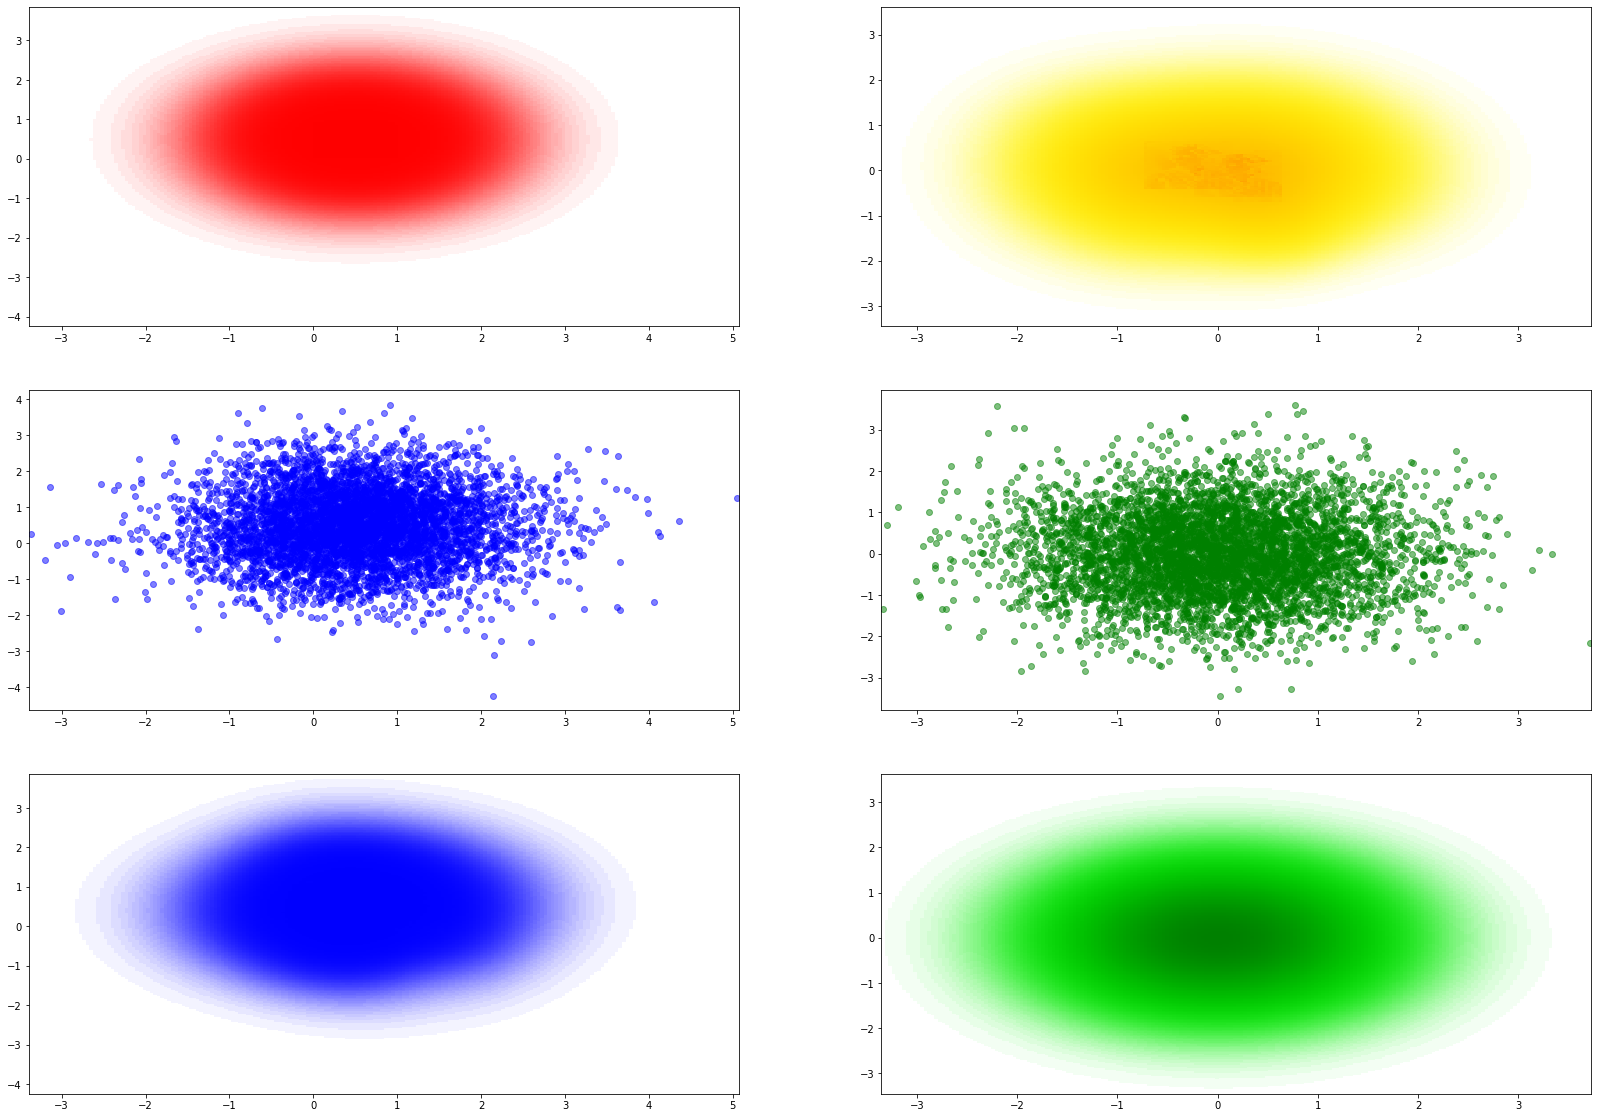

In [29]:
###Visualize TMC dimension 2 ###

model_to_visualize = tmc

linspace = 200
with torch.no_grad():
    model_samples = model_to_visualize.sample_model(num_samples)
    reference_samples = model_to_visualize.reference.sample(num_samples)
    x0_min = min(model_samples[:,0])
    x0_max = max(model_samples[:,0])
    x1_min = min(model_samples[:,1])
    x1_max = max(model_samples[:,1])
    x_grid = torch.cartesian_prod(torch.linspace(x0_min, x0_max,linspace),torch.linspace(x1_min, x1_max,linspace))
    density_model = torch.exp(model_to_visualize.model_log_density(x_grid).reshape(linspace,linspace))
    density_target = torch.exp(model_to_visualize.target_log_density(x_grid).reshape(linspace,linspace))
    z0_min = min(reference_samples[:,0])
    z0_max = max(reference_samples[:,0])
    z1_min = min(reference_samples[:,1])
    z1_max = max(reference_samples[:,1])
    z_grid = torch.cartesian_prod(torch.linspace(z0_min, z0_max,linspace),torch.linspace(z1_min, z1_max,linspace))
    density_proxy = torch.exp(model_to_visualize.proxy_log_density(z_grid).reshape(linspace,linspace))
    density_reference = torch.exp(model_to_visualize.reference.log_density(z_grid).reshape(linspace,linspace))
fig = plt.figure(figsize=(28, 20))

ax1 = fig.add_subplot(321)
ax1.pcolormesh(torch.linspace(x0_min, x0_max,linspace),torch.linspace(x1_min, x1_max,linspace), density_target.T, cmap = red_cmap)

ax2 = fig.add_subplot(322)
ax2.pcolormesh(torch.linspace(z0_min, z0_max,linspace),torch.linspace(z1_min, z1_max,linspace), density_proxy.T, cmap = orange_cmap)

ax3 = fig.add_subplot(323, sharex=ax1)
ax3.scatter(model_samples[:,0], model_samples[:,1], alpha = 0.5,color=blue_color, label="Output model density")

ax4 = fig.add_subplot(324, sharex=ax2)
ax4.scatter(reference_samples[:, 0],reference_samples[:, 1], alpha=0.5, color=green_color,label='Reference samples')

ax5 = fig.add_subplot(325, sharex=ax1)
ax5.pcolormesh(torch.linspace(x0_min, x0_max,linspace),torch.linspace(x1_min, x1_max,linspace), density_model.T, cmap = blue_cmap)

ax6 = fig.add_subplot(326, sharex=ax2)
ax6.pcolormesh(torch.linspace(z0_min, z0_max,linspace),torch.linspace(z1_min, z1_max,linspace), density_reference.T, cmap = green_cmap)